<a href="https://colab.research.google.com/github/PROACT-team/2023-Loss-of-autonomy-in-swallowing/blob/main/5_1_SNUH_data_cleaning_and_preprocessing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
pip install pyreadr

In [ ]:
# Load packages
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pyreadr

In [ ]:
# Read datasets (if using local files)
from google.colab import files
uploaded = files.upload()

In [ ]:
# Read datasets (if using google drive)
base = pyreadr.read_r('/content/drive/MyDrive/Predicting Loss of Autonomy/Raw data/SNUH/base.rds')[None].drop(columns=['Name'])
dx = pyreadr.read_r('/content/drive/MyDrive/Predicting Loss of Autonomy/Raw data/SNUH/dx.rds')[None]
event = pyreadr.read_r('/content/drive/MyDrive/Predicting Loss of Autonomy/Raw data/SNUH/event.rds')[None]
course = pyreadr.read_r('/content/drive/MyDrive/Predicting Loss of Autonomy/Raw data/SNUH/course.rds')[None]

In [ ]:
# import raw data (if using google drive)
frs1 = pd.read_excel('/content/drive/MyDrive/Predicting Loss of Autonomy/Raw data/SNUH/20170420_20191030_ALSFRS.xlsx', engine='openpyxl')
frs2 = pd.read_excel('/content/drive/MyDrive/Predicting Loss of Autonomy/Raw data/SNUH/20170612_20210726_ALSFRS.xlsx', engine='openpyxl')

In [ ]:
#Change column name and drop unnecessary columns
frs1.columns = ['Hosp_ID', 'Date_visit_time', 'Date_visit', 'Q1_Speech', 'Q2_Salivation', 'Q3_Swallowing', 'Q4_Handwriting', 'Q5a_Cutting_without_Gastrostomy', 'Q5b_Cutting_with_Gastrostomy',
       'Q6_Dressing_and_Hygiene', 'Q7_Turning_in_Bed', 'Q8_Walking', 'Q9_Climbing_Stairs', 'R1_Dyspnea', 'R2_Orthopnea', 'R3_Respiratory_Insufficiency', 'ALSFRS_R_Total', 'MiToS stage(0-5)', 'ALSFRS_Total']
frs1 = frs1.drop(columns=['Date_visit_time', 'MiToS stage(0-5)', 'ALSFRS_Total'])

frs2.columns = ['Hosp_ID', 'Date_visit_time', 'Date_visit', 'Q1_Speech', 'Q2_Salivation', 'Q3_Swallowing', 'Q4_Handwriting', 'Q5a_Cutting_without_Gastrostomy', 'Q5b_Cutting_with_Gastrostomy',
       'Q6_Dressing_and_Hygiene', 'Q7_Turning_in_Bed', 'Q8_Walking', 'Q9_Climbing_Stairs', 'R1_Dyspnea', 'R2_Orthopnea', 'R3_Respiratory_Insufficiency', 'ALSFRS_R_Total', 'MiToS stage(0-5)']
frs2 = frs2.drop(columns=['Date_visit_time', 'MiToS stage(0-5)'])

In [ ]:
frs = pd.concat([frs1, frs2])
# Add StudyID column
frs_with_id = pd.merge(frs, base[['Study_ID', 'Hosp_ID']], on='Hosp_ID', how='inner')

# 1. Original data (n=469)

In [ ]:
#patients with definite, probable, or probable lab-supported ALS according to the revised El Escorial crtieria
frs_ALS = frs_with_id.query("Study_ID == {0}".format(base.query('Dx == "ALS"')['Study_ID'].unique().tolist()))

#Register period is between Jan 2017 and July 2021
frs_ALS_registry = frs_ALS.query("Study_ID == {0}".format(dx[pd.to_datetime(dx['Date_enrollment'])>='2017-01-01']['Study_ID'].unique().tolist()))

print(len(frs_ALS_registry['Study_ID'].unique().tolist()),  "patients are in the original data ")

469 patients are in the original data 


# 2. Filtered (I) (n=465) : inconsistent patient ID (n=4)

In [ ]:
# Inconsistent patient ID (Same Hosp_ID, but different Study_ID)
base[base.duplicated('Hosp_ID', keep=False)].query("Study_ID =={0}".format(frs_ALS_registry['Study_ID'].unique().tolist())) # 1540, 1516, 1384, 1356 are inconsistent IDs

,Study_ID,Hosp_ID,Sex,Dx,Age_dx
290,1540.0,53546377.0,M,ALS,71.0
314,1516.0,53546377.0,M,ALS,63.0
445,1384.0,52193547.0,M,ALS,60.0
473,1356.0,52193547.0,M,ALS,60.0


In [ ]:
# Inconsistent patient ID (Same Study_ID, but different Hosp_ID)
base[base.duplicated('Study_ID', keep=False)].query("Study_ID =={0}".format(frs_ALS_registry['Study_ID'].unique().tolist()))

,Study_ID,Hosp_ID,Sex,Dx,Age_dx


In [ ]:
inconsistent_list = [1540, 1516, 1384, 1356]

In [ ]:
first_filtered_frs = frs_ALS_registry.query("Study_ID!={0}".format(inconsistent_list))
len(first_filtered_frs['Study_ID'].unique().tolist())

465

# 3. Filtered (II) (n=456) : ALS_hx
# : exclude patients with No or incomplete ALS history (n=3)
# : exclude patients with Time from diagnosis <0 (n=1), Time from onset <0 (n=1), or Time from diagnosis > Time from onset (n=4)

In [ ]:
ALS_hx = dx[['Study_ID', 'Date_onset', 'Date_dx', 'Date_enrollment', 'Onset_region']]
ALS_hx.head()

,Study_ID,Date_onset,Date_dx,Date_enrollment,Onset_region
0,11872.0,2016-11-01,2017-12-01,2017-12-12,LS
1,11871.0,2017-01-01,2017-11-01,2017-12-27,B
2,11862.0,2015-03-01,2016-11-01,2017-09-18,C
3,11861.0,2017-05-01,2017-09-01,2017-11-01,LS
4,11852.0,2015-06-01,2016-12-01,2018-01-02,LS


In [ ]:
from pandas._libs.tslibs.fields import round_nsint64
# Calculate onset_delta, diag_delta, diag_minus_onset in months
ALS_hx['onset_delta'] = -round((pd.to_datetime(ALS_hx['Date_onset'])- pd.to_datetime(ALS_hx['Date_enrollment'])) / np.timedelta64(1,'D') * 12/365)
ALS_hx['diag_delta'] = -round((pd.to_datetime(ALS_hx['Date_dx'])- pd.to_datetime(ALS_hx['Date_enrollment'])) / np.timedelta64(1,'D') * 12/365)
ALS_hx['diag_minus_onset'] = ALS_hx['diag_delta']-ALS_hx['onset_delta'] #define 'diag_minus_onset' as time difference between onset and diagnosis

# Save Data_enrollment (for feature delata calculation in time-resolved feature)
date_enroll = ALS_hx[['Study_ID', 'Date_enrollment']]
ALS_hx.drop(columns = ['Date_onset','Date_enrollment','Date_dx'], inplace = True)

# Bubar_onset = 1, non-Bulbar_onset = 0
ALS_hx.rename(columns = {'Onset_region':'onset_site'}, inplace = True)
ALS_hx = ALS_hx.replace({'onset_site':{"LS":0, "B":1, "C":0, "BL":1}})

In [ ]:
ALS_hx.query("Study_ID == {0}".format(first_filtered_frs['Study_ID'].unique().tolist()))

,Study_ID,onset_site,onset_delta,diag_delta,diag_minus_onset
0,11872.0,0,13.0,0.0,-13.0
1,11871.0,1,12.0,2.0,-10.0
4,11852.0,0,31.0,13.0,-18.0
117,1753.0,0,30.0,1.0,-29.0
128,1742.0,0,8.0,NaN,NaN
...,...,...,...,...,...
807,1017.0,1,7.0,1.0,-6.0
811,1013.0,0,121.0,1.0,-120.0
815,1009.0,1,11.0,3.0,-8.0
819,1005.0,0,5.0,2.0,-3.0


In [ ]:
# patients who have incomplete ALS history
ALS_hx[ALS_hx.isna( ).any(axis=1)].query("Study_ID == {0}".format(first_filtered_frs['Study_ID'].unique().tolist()))

,Study_ID,onset_site,onset_delta,diag_delta,diag_minus_onset
128,1742.0,0,8.0,NaN,NaN
535,1293.0,1,9.0,NaN,NaN
749,1075.0,NaN,NaN,NaN,NaN


In [ ]:
incomplete_ALS_history = ALS_hx[ALS_hx.isna( ).any(axis=1)].query("Study_ID == {0}".format(first_filtered_frs['Study_ID'].unique().tolist()))['Study_ID'].unique().tolist()

In [ ]:
second_filtered_frs1 = first_filtered_frs.query("Study_ID!={0}".format(incomplete_ALS_history))

In [ ]:
# those with diag_delta <0
ALS_hx.query("(diag_delta < 0)").query("Study_ID == {0}".format(second_filtered_frs1['Study_ID'].unique().tolist()))

,Study_ID,onset_site,onset_delta,diag_delta,diag_minus_onset
299,1530.0,0,17.0,-5.0,-22.0


In [ ]:
# those with onset_delta <0
ALS_hx.query("(diag_delta >= 0) and (onset_delta<0)").query("Study_ID == {0}".format(second_filtered_frs1['Study_ID'].unique().tolist()))

,Study_ID,onset_site,onset_delta,diag_delta,diag_minus_onset
406,1422.0,1,-3.0,1.0,4.0


In [ ]:
# those with diag_delta > onset_delta
ALS_hx.query("(diag_delta >= 0) and (onset_delta>=0) and (diag_delta > onset_delta)").query("Study_ID == {0}".format(second_filtered_frs1['Study_ID'].unique().tolist()))

,Study_ID,onset_site,onset_delta,diag_delta,diag_minus_onset
165,1694.0,1,6.0,13.0,7.0
171,1659.0,0,10.0,14.0,4.0
173,1657.0,0,2.0,3.0,1.0
392,1436.0,1,4.0,11.0,7.0


In [ ]:
# 5 patient has errorneous value in ALS_hx
errorneous_ALS_hx = [1530, 1422, 1694, 1659, 1657, 1436]

In [ ]:
second_filtered_frs2 = second_filtered_frs1.query("Study_ID!={0}".format(errorneous_ALS_hx))
len(second_filtered_frs2['Study_ID'].unique().tolist())

456

# Demographic records; either none (n=0) or incomplete (n=0)

In [ ]:
demographics = dx[['Study_ID', 'Sex', 'Age_dx']].query("Study_ID == {0}".format(second_filtered_frs2['Study_ID'].unique().tolist()))
demographics

,Study_ID,Sex,Age_dx
0,11872.0,M,66.0
1,11871.0,M,61.0
4,11852.0,F,20.0
117,1753.0,M,66.0
134,1736.0,M,62.0
...,...,...,...
807,1017.0,F,72.0
811,1013.0,M,34.0
815,1009.0,F,73.0
819,1005.0,M,31.0


In [ ]:
demographics.isnull().sum()

Study_ID    0
Sex         0
Age_dx      0
dtype: int64

#4. Filtered (III) (n=444) :patients with every records in ALSFRS errorneous
# - visit date missing (n=9)
# - errorneous Q5a,b (n=3)

## remove errorneous record (53 records removed, 6 patients removed)

#### (1) 'Date_visit' missing (61 records removed, 9 patient removed)

In [ ]:
second_filtered_frs2[second_filtered_frs2['Date_visit'].isnull()==True]

,Hosp_ID,Date_visit,Q1_Speech,Q2_Salivation,Q3_Swallowing,Q4_Handwriting,Q5a_Cutting_without_Gastrostomy,Q5b_Cutting_with_Gastrostomy,Q6_Dressing_and_Hygiene,Q7_Turning_in_Bed,Q8_Walking,Q9_Climbing_Stairs,R1_Dyspnea,R2_Orthopnea,R3_Respiratory_Insufficiency,ALSFRS_R_Total,Study_ID
3,49410075,NaN,2.0,1.0,2.0,2.0,3.0,NaN,2.0,2.0,2.0,1.0,1.0,2.0,3.0,23.0,1017.0
6,48147002,NaN,0.0,0.0,1.0,3.0,3.0,NaN,1.0,2.0,3.0,3.0,4.0,3.0,4.0,27.0,1098.0
19,49244317,NaN,4.0,4.0,3.0,3.0,3.0,NaN,1.0,1.0,1.0,0.0,2.0,3.0,4.0,29.0,1020.0
35,49382048,NaN,3.0,4.0,3.0,0.0,0.0,NaN,0.0,1.0,0.0,0.0,2.0,3.0,4.0,20.0,1022.0
45,44753599,NaN,2.0,3.0,3.0,0.0,1.0,NaN,1.0,2.0,2.0,1.0,4.0,4.0,4.0,27.0,1145.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2073,40882534,NaN,3.0,3.0,3.0,1.0,2.0,NaN,1.0,1.0,2.0,0.0,0.0,0.0,2.0,18.0,1548.0
2148,54139912,NaN,3.0,3.0,3.0,3.0,3.0,NaN,3.0,3.0,3.0,2.0,4.0,4.0,4.0,38.0,1569.0
2232,54360590,NaN,3.0,3.0,3.0,1.0,3.0,NaN,2.0,2.0,3.0,3.0,4.0,4.0,4.0,35.0,1599.0
2323,54364206,NaN,3.0,4.0,3.0,1.0,0.0,NaN,0.0,3.0,2.0,0.0,4.0,3.0,4.0,27.0,1648.0


In [ ]:
third_filtered_frs1 = second_filtered_frs2[second_filtered_frs2['Date_visit'].isnull()==False]
print(len(second_filtered_frs2[second_filtered_frs2['Date_visit'].isnull()==True]), "observations were removed")
print("Patient number has reduced : from",len(second_filtered_frs2['Study_ID'].unique().tolist()) , 'to', len(third_filtered_frs1['Study_ID'].unique().tolist()))

61 observations were removed
Patient number has reduced : from 456 to 447


#### (2) Drop duplicates; (6 records removed, 0 patient removed)

In [ ]:
third_filtered_frs1[third_filtered_frs1.duplicated(keep=False)] # 2 observations have been duplicated, so only one will be saved

,Hosp_ID,Date_visit,Q1_Speech,Q2_Salivation,Q3_Swallowing,Q4_Handwriting,Q5a_Cutting_without_Gastrostomy,Q5b_Cutting_with_Gastrostomy,Q6_Dressing_and_Hygiene,Q7_Turning_in_Bed,Q8_Walking,Q9_Climbing_Stairs,R1_Dyspnea,R2_Orthopnea,R3_Respiratory_Insufficiency,ALSFRS_R_Total,Study_ID
226,49067440,2017-06-12,2.0,4.0,3.0,2.0,2.0,NaN,1.0,2.0,3.0,1.0,3.0,3.0,4.0,30.0,1062.0
228,49067440,2017-06-12,2.0,4.0,3.0,2.0,2.0,NaN,1.0,2.0,3.0,1.0,3.0,3.0,4.0,30.0,1062.0
1725,52978281,2019-12-23,4.0,4.0,4.0,3.0,2.0,NaN,2.0,2.0,3.0,1.0,4.0,4.0,4.0,37.0,1459.0
1726,52978281,2019-12-23,4.0,4.0,4.0,3.0,2.0,NaN,2.0,2.0,3.0,1.0,4.0,4.0,4.0,37.0,1459.0


In [ ]:
third_filtered_frs2 = third_filtered_frs1.drop_duplicates(keep="first")

In [ ]:
third_filtered_frs2[third_filtered_frs2.duplicated(subset=['Study_ID','Date_visit'], keep=False)]
#Another 2 observations have been duplicated but with different ALSFRS_R_Total score in the same day
#Both of duplicated observations will be deleted at this time

,Hosp_ID,Date_visit,Q1_Speech,Q2_Salivation,Q3_Swallowing,Q4_Handwriting,Q5a_Cutting_without_Gastrostomy,Q5b_Cutting_with_Gastrostomy,Q6_Dressing_and_Hygiene,Q7_Turning_in_Bed,Q8_Walking,Q9_Climbing_Stairs,R1_Dyspnea,R2_Orthopnea,R3_Respiratory_Insufficiency,ALSFRS_R_Total,Study_ID
86,49460296,2018-03-05,4.0,3.0,3.0,4.0,1.0,NaN,0.0,1.0,1.0,0.0,2.0,3.0,4.0,26.0,1031.0
90,49460296,2018-03-05,4.0,4.0,2.0,2.0,2.0,NaN,1.0,1.0,2.0,0.0,4.0,4.0,4.0,30.0,1031.0
96,42029656,2018-11-05,2.0,2.0,3.0,3.0,3.0,NaN,3.0,2.0,2.0,0.0,4.0,4.0,4.0,32.0,1188.0
97,42029656,2018-11-05,4.0,4.0,4.0,3.0,2.0,NaN,3.0,4.0,3.0,1.0,4.0,4.0,4.0,40.0,1188.0


In [ ]:
third_filtered_frs3 = third_filtered_frs2.drop_duplicates(subset=['Study_ID', 'Date_visit'], keep=False)

In [ ]:
print("6 observations were removed")
print("Patient number has maintained : from",len(third_filtered_frs1['Study_ID'].unique().tolist()) , 'to', len(third_filtered_frs3['Study_ID'].unique().tolist()))


6 observations were removed
Patient number has maintained : from 447 to 447


#### (3) ALSFRS-R Q5a and Q5b both missing or Q5a and Q5b both filled : (13 records removed, 3 patients removed)

In [ ]:
third_filtered_frs4 = third_filtered_frs3.copy()

In [ ]:
# Define function returning df with calculated feature delta for time-resolved feautures
def cal_feature_delta(df, date_enroll):
  df1 = pd.merge(df, date_enroll)
  df1['feature_delta'] = (pd.to_datetime(df1['Date_visit'])- pd.to_datetime(df1['Date_enrollment'])) / np.timedelta64(1,'D') * 12/365
  df1 = df1.sort_values(by=['SubjectID', 'feature_delta'], axis=0).reset_index().drop(columns='index')
  df1.drop(columns = ['Date_visit','Date_enrollment'], inplace = True)
  return df1

In [ ]:
third_filtered_frs4.rename(columns = {'Study_ID':'SubjectID'},inplace=True)

date_enroll = dx[['Study_ID', 'Date_enrollment']]
date_enroll.columns=['SubjectID', 'Date_enrollment']
alsfrs_R_raw = cal_feature_delta(third_filtered_frs4, date_enroll)


alsfrs_R_raw = alsfrs_R_raw[['SubjectID','feature_delta', 'Q1_Speech', 'Q2_Salivation', 'Q3_Swallowing', 'Q4_Handwriting',
       'Q5a_Cutting_without_Gastrostomy', 'Q5b_Cutting_with_Gastrostomy',
       'Q6_Dressing_and_Hygiene', 'Q7_Turning_in_Bed', 'Q8_Walking',
       'Q9_Climbing_Stairs', 'R1_Dyspnea', 'R2_Orthopnea',
       'R3_Respiratory_Insufficiency', 'ALSFRS_R_Total', ]]
alsfrs_R_raw

,SubjectID,feature_delta,Q1_Speech,Q2_Salivation,Q3_Swallowing,Q4_Handwriting,Q5a_Cutting_without_Gastrostomy,Q5b_Cutting_with_Gastrostomy,Q6_Dressing_and_Hygiene,Q7_Turning_in_Bed,Q8_Walking,Q9_Climbing_Stairs,R1_Dyspnea,R2_Orthopnea,R3_Respiratory_Insufficiency,ALSFRS_R_Total
0,1003.0,13.019178,4.0,4.0,4.0,0.0,1.0,NaN,0.0,0.0,1.0,0.0,4.0,4.0,4.0,26.0
1,1003.0,15.780822,4.0,4.0,4.0,0.0,0.0,NaN,0.0,0.0,1.0,0.0,4.0,4.0,4.0,25.0
2,1003.0,19.002740,4.0,4.0,4.0,0.0,0.0,NaN,0.0,0.0,0.0,0.0,4.0,4.0,4.0,24.0
3,1003.0,33.304110,4.0,4.0,4.0,0.0,NaN,0.0,0.0,0.0,0.0,0.0,4.0,4.0,4.0,24.0
4,1005.0,0.920548,4.0,4.0,4.0,1.0,2.0,NaN,1.0,1.0,3.0,1.0,4.0,4.0,4.0,33.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1477,11872.0,0.000000,4.0,4.0,4.0,4.0,4.0,NaN,4.0,4.0,2.0,2.0,4.0,4.0,4.0,44.0
1478,11872.0,4.109589,4.0,4.0,4.0,4.0,3.0,NaN,3.0,3.0,2.0,1.0,4.0,4.0,4.0,40.0
1479,11872.0,5.950685,4.0,4.0,4.0,4.0,3.0,NaN,3.0,3.0,1.0,0.0,4.0,4.0,4.0,38.0
1480,11872.0,10.323288,4.0,4.0,4.0,3.0,2.0,NaN,3.0,2.0,1.0,0.0,4.0,4.0,4.0,35.0


In [ ]:
alsfrs_R_raw_Q5 = alsfrs_R_raw[['SubjectID', 'feature_delta', 'Q5a_Cutting_without_Gastrostomy', 'Q5b_Cutting_with_Gastrostomy']]

In [ ]:
# patients with Q5a and Q5b both missing
both_Q5_missing = pd.merge(alsfrs_R_raw_Q5[alsfrs_R_raw_Q5['Q5a_Cutting_without_Gastrostomy'].isnull()],
         alsfrs_R_raw_Q5[alsfrs_R_raw_Q5['Q5b_Cutting_with_Gastrostomy'].isnull()]
         , on=['SubjectID','feature_delta', 'Q5a_Cutting_without_Gastrostomy', 'Q5b_Cutting_with_Gastrostomy']
         , how='inner')
both_Q5_missing

,SubjectID,feature_delta,Q5a_Cutting_without_Gastrostomy,Q5b_Cutting_with_Gastrostomy
0,1088.0,2.038356,NaN,NaN
1,1140.0,12.197260,NaN,NaN
2,1150.0,11.736986,NaN,NaN
3,1159.0,25.742466,NaN,NaN
4,1266.0,0.000000,NaN,NaN
5,1414.0,10.126027,NaN,NaN
6,1490.0,5.983562,NaN,NaN
7,1518.0,6.213699,NaN,NaN
8,1519.0,6.476712,NaN,NaN
9,1559.0,3.156164,NaN,NaN


In [ ]:
# patients with Q5a and Q5b both filled
both_Q5_filled = pd.merge(alsfrs_R_raw_Q5[~alsfrs_R_raw_Q5['Q5a_Cutting_without_Gastrostomy'].isnull()]
         , alsfrs_R_raw_Q5[~alsfrs_R_raw_Q5['Q5b_Cutting_with_Gastrostomy'].isnull()]
         , on=['SubjectID','feature_delta', 'Q5a_Cutting_without_Gastrostomy', 'Q5b_Cutting_with_Gastrostomy']
         , how='inner')
both_Q5_filled

,SubjectID,feature_delta,Q5a_Cutting_without_Gastrostomy,Q5b_Cutting_with_Gastrostomy


In [ ]:
# drop these data
third_filtered_frs4 = pd.merge(pd.concat([both_Q5_missing, both_Q5_filled]), alsfrs_R_raw, how='outer', indicator = True).query('_merge == "right_only"').drop(columns=['_merge'])
third_filtered_frs4

,SubjectID,feature_delta,Q5a_Cutting_without_Gastrostomy,Q5b_Cutting_with_Gastrostomy,Q1_Speech,Q2_Salivation,Q3_Swallowing,Q4_Handwriting,Q6_Dressing_and_Hygiene,Q7_Turning_in_Bed,Q8_Walking,Q9_Climbing_Stairs,R1_Dyspnea,R2_Orthopnea,R3_Respiratory_Insufficiency,ALSFRS_R_Total
13,1003.0,13.019178,1.0,NaN,4.0,4.0,4.0,0.0,0.0,0.0,1.0,0.0,4.0,4.0,4.0,26.0
14,1003.0,15.780822,0.0,NaN,4.0,4.0,4.0,0.0,0.0,0.0,1.0,0.0,4.0,4.0,4.0,25.0
15,1003.0,19.002740,0.0,NaN,4.0,4.0,4.0,0.0,0.0,0.0,0.0,0.0,4.0,4.0,4.0,24.0
16,1003.0,33.304110,NaN,0.0,4.0,4.0,4.0,0.0,0.0,0.0,0.0,0.0,4.0,4.0,4.0,24.0
17,1005.0,0.920548,2.0,NaN,4.0,4.0,4.0,1.0,1.0,1.0,3.0,1.0,4.0,4.0,4.0,33.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1477,11872.0,0.000000,4.0,NaN,4.0,4.0,4.0,4.0,4.0,4.0,2.0,2.0,4.0,4.0,4.0,44.0
1478,11872.0,4.109589,3.0,NaN,4.0,4.0,4.0,4.0,3.0,3.0,2.0,1.0,4.0,4.0,4.0,40.0
1479,11872.0,5.950685,3.0,NaN,4.0,4.0,4.0,4.0,3.0,3.0,1.0,0.0,4.0,4.0,4.0,38.0
1480,11872.0,10.323288,2.0,NaN,4.0,4.0,4.0,3.0,3.0,2.0,1.0,0.0,4.0,4.0,4.0,35.0


In [ ]:
third_filtered_frs4['Q5_Cutting'] = alsfrs_R_raw['Q5a_Cutting_without_Gastrostomy'].fillna(0) + alsfrs_R_raw['Q5b_Cutting_with_Gastrostomy'].fillna(0)
third_filtered_frs4.drop(columns=['Q5a_Cutting_without_Gastrostomy', 'Q5b_Cutting_with_Gastrostomy'], inplace=True)
third_filtered_frs4

,SubjectID,feature_delta,Q1_Speech,Q2_Salivation,Q3_Swallowing,Q4_Handwriting,Q6_Dressing_and_Hygiene,Q7_Turning_in_Bed,Q8_Walking,Q9_Climbing_Stairs,R1_Dyspnea,R2_Orthopnea,R3_Respiratory_Insufficiency,ALSFRS_R_Total,Q5_Cutting
13,1003.0,13.019178,4.0,4.0,4.0,0.0,0.0,0.0,1.0,0.0,4.0,4.0,4.0,26.0,0.0
14,1003.0,15.780822,4.0,4.0,4.0,0.0,0.0,0.0,1.0,0.0,4.0,4.0,4.0,25.0,0.0
15,1003.0,19.002740,4.0,4.0,4.0,0.0,0.0,0.0,0.0,0.0,4.0,4.0,4.0,24.0,1.0
16,1003.0,33.304110,4.0,4.0,4.0,0.0,0.0,0.0,0.0,0.0,4.0,4.0,4.0,24.0,0.0
17,1005.0,0.920548,4.0,4.0,4.0,1.0,1.0,1.0,3.0,1.0,4.0,4.0,4.0,33.0,4.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1477,11872.0,0.000000,4.0,4.0,4.0,4.0,4.0,4.0,2.0,2.0,4.0,4.0,4.0,44.0,4.0
1478,11872.0,4.109589,4.0,4.0,4.0,4.0,3.0,3.0,2.0,1.0,4.0,4.0,4.0,40.0,3.0
1479,11872.0,5.950685,4.0,4.0,4.0,4.0,3.0,3.0,1.0,0.0,4.0,4.0,4.0,38.0,3.0
1480,11872.0,10.323288,4.0,4.0,4.0,3.0,3.0,2.0,1.0,0.0,4.0,4.0,4.0,35.0,2.0


In [ ]:
print("13 observations were removed")
print("Patient number has reduced : from",len(third_filtered_frs3['Study_ID'].unique().tolist()) , 'to', len(third_filtered_frs4['SubjectID'].unique().tolist()))

13 observations were removed
Patient number has reduced : from 447 to 444


# 5. Filtered (IV) (n=267)
# ALSFRS-R : exclude patients with no record (n=16) or incomplete record (n=10) for the first 3 months
# exclude patients with less than 2 observation (n=151)

## ALSFRS-R within 3 months (135 patients removed)

#### (1) No record within first 3 months (n=16)

In [ ]:
ALSFRS_R_3months = third_filtered_frs4.query('(feature_delta <= 3.0) and (feature_delta >= 0)')
print("ALSFRS for the first 3 months contains", len(ALSFRS_R_3months['SubjectID'].unique().tolist()), " patients")
print(len(third_filtered_frs4['SubjectID'].unique().tolist())-len((ALSFRS_R_3months['SubjectID'].unique().tolist())), "patients are excluded because they had no ALSFRS record for first 3 months")

ALSFRS for the first 3 months contains 428  patients
16 patients are excluded because they had no ALSFRS record for first 3 months


In [ ]:
fourth_filtered_frs1 = third_filtered_frs4.query("SubjectID=={0}".format(ALSFRS_R_3months['SubjectID'].unique().tolist()))

In [ ]:
print(len(fourth_filtered_frs1['SubjectID'].unique().tolist()))

428


#### (2) Incomplete record for first 3 months (n=10)

In [ ]:
# Check missing data
ALSFRS_R_3months.isnull().sum()

SubjectID                       0
feature_delta                   0
Q1_Speech                       0
Q2_Salivation                   0
Q3_Swallowing                   2
Q4_Handwriting                  3
Q6_Dressing_and_Hygiene         1
Q7_Turning_in_Bed               0
Q8_Walking                      1
Q9_Climbing_Stairs              0
R1_Dyspnea                      0
R2_Orthopnea                    1
R3_Respiratory_Insufficiency    3
ALSFRS_R_Total                  0
Q5_Cutting                      0
dtype: int64

In [ ]:
# If any item of 3 month ALSFRS-R is missing, that patient would be excluded
exclude_3mo_missing = ALSFRS_R_3months[ALSFRS_R_3months.isnull().any(axis=1)]['SubjectID'].unique().tolist()
fourth_filtered_frs2 = fourth_filtered_frs1.query("SubjectID != {0}".format(exclude_3mo_missing))
print(len(fourth_filtered_frs2['SubjectID'].unique().tolist()))

418


#### (3) Less than 2 observations (n=151)

In [ ]:
alsfrs_R_cleaned = fourth_filtered_frs2.sort_values(by=['SubjectID', 'feature_delta'])

alsfrs_grouped = alsfrs_R_cleaned.groupby('SubjectID').agg(['first', 'last'])
alsfrs_grouped = alsfrs_grouped.reset_index()
alsfrs_grouped.head()

SubjectID feature_delta            Q1_Speech      Q2_Salivation       \
                    first       last     first last         first last   
0    1005.0      0.920548  30.378082       4.0  2.0           4.0  2.0   
1    1009.0      2.991781   2.991781       0.0  0.0           1.0  1.0   
2    1017.0      0.000000   3.024658       3.0  3.0           4.0  2.0   
3    1019.0      0.000000  20.515068       4.0  2.0           4.0  4.0   
4    1020.0      0.000000   2.926027       4.0  4.0           4.0  4.0   

  Q3_Swallowing      Q4_Handwriting  ... R1_Dyspnea      R2_Orthopnea       \
          first last          first  ...      first last        first last   
0           4.0  1.0            1.0  ...        4.0  4.0          4.0  4.0   
1           2.0  2.0            0.0  ...        4.0  4.0          4.0  4.0   
2           3.0  3.0            2.0  ...        4.0  1.0          4.0  3.0   
3           4.0  2.0            3.0  ...        4.0  1.0          4.0  2.0   
4           4.0  4.0            4.0  ...        4.0  2.0          4.0  4.0   

  R3_Respiratory_Insufficiency      ALSFRS_R_Total       Q5_Cutting       
                         first last          first  last      first last  
0                          4.0  4.0           33.0  19.0        4.0  1.0  
1                          4.0  4.0           16.0  16.0        4.0  4.0  
2                          4.0  4.0           33.0  27.0        4.0  3.0  
3                          4.0  4.0           42.0  21.0        3.0  1.0  
4                          4.0  4.0           40.0  30.0        1.0  0.0  

[5 rows x 29 columns]

In [ ]:
# 151 patients with only 1 observation
_1_observation = alsfrs_grouped[alsfrs_grouped[('feature_delta', 'last')]== alsfrs_grouped[('feature_delta', 'first')]]
_1_observation

SubjectID feature_delta           Q1_Speech      Q2_Salivation       \
                      first      last     first last         first last   
1      1009.0      2.991781  2.991781       0.0  0.0           1.0  1.0   
6      1022.0      0.000000  0.000000       3.0  3.0           4.0  4.0   
7      1023.0      0.000000  0.000000       3.0  3.0           4.0  4.0   
8      1025.0      0.000000  0.000000       3.0  3.0           4.0  4.0   
9      1026.0      0.000000  0.000000       3.0  3.0           4.0  4.0   
..        ...           ...       ...       ...  ...           ...  ...   
411    1726.0      0.000000  0.000000       3.0  3.0           2.0  2.0   
412    1730.0      0.000000  0.000000       4.0  4.0           4.0  4.0   
413    1736.0      0.000000  0.000000       4.0  4.0           4.0  4.0   
414    1753.0      0.000000  0.000000       3.0  3.0           4.0  4.0   
415   11852.0      0.000000  0.000000       3.0  3.0           4.0  4.0   

    Q3_Swallowing      Q4_Handwriting  ... R1_Dyspnea      R2_Orthopnea       \
            first last          first  ...      first last        first last   
1             2.0  2.0            0.0  ...        4.0  4.0          4.0  4.0   
6             3.0  3.0            0.0  ...        3.0  3.0          4.0  4.0   
7             3.0  3.0            4.0  ...        4.0  4.0          4.0  4.0   
8             3.0  3.0            3.0  ...        4.0  4.0          4.0  4.0   
9             0.0  0.0            0.0  ...        1.0  1.0          2.0  2.0   
..            ...  ...            ...  ...        ...  ...          ...  ...   
411           3.0  3.0            4.0  ...        3.0  3.0          4.0  4.0   
412           4.0  4.0            3.0  ...        4.0  4.0          4.0  4.0   
413           4.0  4.0            0.0  ...        4.0  4.0          4.0  4.0   
414           3.0  3.0            3.0  ...        4.0  4.0          4.0  4.0   
415           3.0  3.0            1.0  ...        4.0  4.0          4.0  4.0   

    R3_Respiratory_Insufficiency      ALSFRS_R_Total       Q5_Cutting       
                           first last          first  last      first last  
1                            4.0  4.0           16.0  16.0        4.0  4.0  
6                            4.0  4.0           27.0  27.0        3.0  3.0  
7                            4.0  4.0           44.0  44.0        2.0  2.0  
8                            4.0  4.0           44.0  44.0        0.0  0.0  
9                            4.0  4.0           14.0  14.0        0.0  0.0  
..                           ...  ...            ...   ...        ...  ...  
411                          4.0  4.0           43.0  43.0        4.0  4.0  
412                          4.0  4.0           42.0  42.0        3.0  3.0  
413                          4.0  4.0           31.0  31.0        2.0  2.0  
414                          4.0  4.0           35.0  35.0        3.0  3.0  
415                          4.0  4.0           30.0  30.0        1.0  1.0  

[151 rows x 29 columns]

In [ ]:
alsfrs_grouped = alsfrs_grouped[alsfrs_grouped[('feature_delta', 'last')]!= alsfrs_grouped[('feature_delta', 'first')]]

In [ ]:
fourth_filtered_frs3 = alsfrs_R_cleaned.query("SubjectID == {0}".format(alsfrs_grouped['SubjectID'].unique().tolist()))

In [ ]:
len(fourth_filtered_frs3['SubjectID'].unique().tolist())

267

# 6. Filtered(V) (n=217)
# Event (n=8) or Censoring (n=42) occured within 3 months after enrollment (n=50)

In [ ]:
Filtered_3_ALSFRS_Q3 = fourth_filtered_frs3[['SubjectID', 'feature_delta', 'Q3_Swallowing']]

In [ ]:
# Find the first time of [ALSFRS_Q3 <= 1.0]
Target_event = Filtered_3_ALSFRS_Q3[Filtered_3_ALSFRS_Q3['Q3_Swallowing']<=1].groupby('SubjectID').agg(['first']).reset_index()
Target_event.head()

,SubjectID,feature_delta,Q3_Swallowing
,,first,first
0,1005.0,30.378082,1.0
1,1030.0,24.394521,1.0
2,1046.0,24.591781,1.0
3,1058.0,23.704110,0.0
4,1063.0,4.372603,0.0


In [ ]:
# Coding [ALSFRS-Q3<=1] event as '1'
Target_event_1 = Target_event[[('SubjectID',''), ('feature_delta', 'first')]]
Target_event_1.columns = ['SubjectID', 'time_LOA']

Target_event_1_subject_list = list(Target_event['SubjectID'])

Target_event_1['status_LOA'] = 1
print("There are",len(Target_event_1['SubjectID'].unique()), "subjects whose loss of autonomy = 1")

# Otherwise '0'
Target_event_0 = Filtered_3_ALSFRS_Q3[~Filtered_3_ALSFRS_Q3['SubjectID'].isin(Target_event_1_subject_list)]
Target_event_0 = Target_event_0.groupby('SubjectID').agg(['last']).reset_index().drop(columns=('Q3_Swallowing', 'last'))
Target_event_0.columns = ['SubjectID', 'time_LOA']
Target_event_0['status_LOA'] = 0
print("There are",len(Target_event_0['SubjectID'].unique()), "subjects whose loss of autonomy = 0")

 # There are 40 subjects whose Event = 1
 # There are 227 subjects whose Event = 0

There are 40 subjects whose loss of autonomy = 1
There are 227 subjects whose loss of autonomy = 0


In [ ]:
ALFRS_Q3_coded = pd.concat([Target_event_1, Target_event_0]).sort_values(by='SubjectID', axis=0)
ALFRS_Q3_coded = ALFRS_Q3_coded.reset_index()
ALFRS_Q3_coded.drop(columns='index', inplace=True)

Target_Data = ALFRS_Q3_coded.copy()
Target_Data_subject_list = list(Target_Data['SubjectID'])
Target_Data #267 data

,SubjectID,time_LOA,status_LOA
0,1005.0,30.378082,1
1,1017.0,3.024658,0
2,1019.0,20.515068,0
3,1020.0,2.926027,0
4,1021.0,47.769863,0
...,...,...,...
262,1655.0,2.268493,0
263,1696.0,1.084932,0
264,1722.0,2.531507,0
265,11871.0,12.361644,0


In [ ]:
print(len(Target_Data.query('time_LOA <= 3.0')['SubjectID'].tolist()), 'patients has time_LOA 3 month or less')

50 patients has time_LOA 3 month or less


In [ ]:
Target_Data_snuh = Target_Data.query('time_LOA > 3.0')

# minus 3months for target data value
Target_Data_snuh['time_LOA'] = Target_Data_snuh['time_LOA'] -3.0

Target_Data_snuh

<ipython-input-109-67a1f70a3919>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Target_Data_snuh['time_LOA'] = Target_Data_snuh['time_LOA'] -3.0


,SubjectID,time_LOA,status_LOA
0,1005.0,27.378082,1
1,1017.0,0.024658,0
2,1019.0,17.515068,0
4,1021.0,44.769863,0
6,1030.0,21.394521,1
...,...,...,...
257,1642.0,1.832877,0
259,1650.0,0.484932,0
261,1654.0,0.221918,0
265,11871.0,9.361644,0


In [ ]:
print(len(Target_Data['SubjectID'])-len(Target_Data_snuh['SubjectID']), 'patients were excluded because of early occurrence or censoring')
print(len(Target_Data.query('(time_LOA <= 3.0) and (status_LOA == 0)')), 'out of 50 are early-censored (follow up being < 3mo)')
print(len(Target_Data.query('(time_LOA <= 3.0) and (status_LOA == 1)')), 'out of 50 are early-occured (occurred before 3mo)')

50 patients were excluded because of early occurrence or censoring
42 out of 50 are early-censored (follow up being < 3mo)
8 out of 50 are early-occured (occurred before 3mo)


In [ ]:
# Note that 'time_LOA' is month scaled

In [ ]:
fifth_filtered_frs = fourth_filtered_frs3.query("SubjectID == {0}".format(Target_Data_snuh['SubjectID'].unique().tolist()))

In [ ]:
len(fifth_filtered_frs['SubjectID'].unique().tolist())

217

# 6. Filtered (VI) (n=210)
# Gastrostomy placement occured before registry or within 3 months after enrollment (n=7)



In [ ]:
alsfrs_R_raw_Q5 = alsfrs_R_raw_Q5.query("SubjectID == {0}".format(fifth_filtered_frs['SubjectID'].unique().tolist())).sort_values(['SubjectID', 'feature_delta'])
ALSFRS_R_Q5 = alsfrs_R_raw_Q5.copy()

In [ ]:
# Find the first time of [ALSFRS_Q5b is not NaN]
Target_event = ALSFRS_R_Q5[ALSFRS_R_Q5['Q5b_Cutting_with_Gastrostomy'].notna()].groupby('SubjectID').agg(['first']).reset_index()
Target_event.head()

,SubjectID,feature_delta,Q5a_Cutting_without_Gastrostomy,Q5b_Cutting_with_Gastrostomy
,,first,first,first
0,1017.0,2.169863,NaN,3.0
1,1019.0,13.117808,NaN,4.0
2,1021.0,47.769863,NaN,0.0
3,1037.0,26.860274,NaN,0.0
4,1039.0,14.958904,NaN,4.0


In [ ]:
# Coding [ALSFRS_Q5b is not NaN] event as '1'
Target_event_1 = Target_event[[('SubjectID',''), ('feature_delta', 'first')]]
Target_event_1.columns = ['SubjectID', 'time_GAS']

Target_event_1_subject_list = list(Target_event['SubjectID'])

Target_event_1['status_GAS'] = 1
print("There are",len(Target_event_1['SubjectID'].unique()), "subjects whose Gastrostomy = 1")

# Otherwise '0'
Target_event_0 = ALSFRS_R_Q5[~ALSFRS_R_Q5['SubjectID'].isin(Target_event_1_subject_list)]
Target_event_0 = Target_event_0.groupby('SubjectID').agg(['last']).reset_index().drop(columns=[('Q5a_Cutting_without_Gastrostomy', 'last'), ('Q5b_Cutting_with_Gastrostomy', 'last')])
Target_event_0.columns = ['SubjectID', 'time_GAS']
Target_event_0['status_GAS'] = 0
print("There are",len(Target_event_0['SubjectID'].unique()), "subjects whose Gastrostomy = 0")

# There are 48 subjects whose Gastrostomy = 1
# There are 169 subjects whose Gastrostomy = 0

There are 48 subjects whose Gastrostomy = 1
There are 169 subjects whose Gastrostomy = 0


<ipython-input-115-37e041061722>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Target_event_1['status_GAS'] = 1


In [ ]:
ALFRS_Q5_coded = pd.concat([Target_event_1, Target_event_0]).sort_values(by='SubjectID', axis=0)
ALFRS_Q5_coded = ALFRS_Q5_coded.reset_index()
ALFRS_Q5_coded.drop(columns='index', inplace=True)

Target_Data = ALFRS_Q5_coded.copy()
Target_Data_subject_list = list(Target_Data['SubjectID'])
Target_Data #217 data

,SubjectID,time_GAS,status_GAS
0,1005.0,30.378082,0
1,1017.0,2.169863,1
2,1019.0,13.117808,1
3,1021.0,47.769863,1
4,1030.0,32.942466,0
...,...,...,...
212,1642.0,4.832877,0
213,1650.0,3.484932,0
214,1654.0,3.221918,0
215,11871.0,12.361644,0


In [ ]:
Target_Data.query('time_GAS <= 3.0')

,SubjectID,time_GAS,status_GAS
1,1017.0,2.169863,1
97,1367.0,2.531507,1
103,1380.0,2.695890,1
178,1545.0,0.000000,1
188,1564.0,0.065753,1
192,1573.0,2.235616,1
201,1603.0,0.000000,1


In [ ]:
print(len(Target_Data.query('time_GAS <= 3.0')['SubjectID'].tolist()), 'patients has time_GAS 3 month or less')

7 patients has time_GAS 3 month or less


In [ ]:
sixth_filtered_frs = fifth_filtered_frs.query("SubjectID == {0}".format(Target_Data.query('time_GAS > 3.0')['SubjectID'].unique().tolist()))

In [ ]:
len(sixth_filtered_frs['SubjectID'].unique().tolist())

210

#교수님 질문주신 부분 (10/29)

In [ ]:
pfhong = pd.read_csv("/content/drive/MyDrive/Predicting Loss of Autonomy/Raw data/SNUH/snuh_alsfrs.csv")

In [ ]:
pfhong_with_id = pd.merge(pfhong, dx[['Study_ID', 'Date_enrollment']], on='Study_ID', how='inner')

In [ ]:
len(pfhong_with_id['Study_ID'].unique().tolist())

228

In [ ]:
#교수님이 제거하지 않은 환자 데이터들
pfhong_with_id.query("Study_ID != {0}".format(sixth_filtered_frs['SubjectID'].unique().tolist()))

,Study_ID,Date_visit,ALSFRS_Total,Q1,Q2,Q3,Q4,Q5,Q6,Q7,Q8,Q9,Q10,Q11,Q12,gastrostomy,Date_enrollment
109,1167,2019-11-11,19,1,1,2,2,2,0,1,0,0,2,4,4,False,2017-11-13
110,1167,2020-05-11,19,1,2,2,1,1,0,1,1,0,2,4,4,False,2017-11-13
111,1167,2017-11-12,45,3,4,4,3,3,4,4,4,4,4,4,4,False,2017-11-13
112,1167,2018-03-07,37,3,4,3,3,3,2,3,3,2,3,4,4,False,2017-11-13
113,1167,2018-05-30,36,2,4,3,3,3,2,3,3,1,4,4,4,False,2017-11-13
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1083,1093,2018-05-21,43,4,2,3,4,3,4,4,4,4,3,4,4,False,2017-07-03
1084,1093,2019-03-25,45,4,2,4,4,3,4,4,4,4,4,4,4,False,2017-07-03
1085,1099,2017-12-11,40,2,3,3,4,4,2,4,3,3,4,4,4,False,2017-07-17
1086,1099,2018-03-05,42,3,3,3,2,3,4,4,4,4,4,4,4,False,2017-07-17


In [ ]:
mystery_list = pfhong_with_id.query("Study_ID != {0}".format(sixth_filtered_frs['SubjectID'].unique().tolist()))['Study_ID'].unique().tolist()

In [ ]:
len(pfhong_with_id.query("Study_ID != {0}".format(sixth_filtered_frs['SubjectID'].unique().tolist()))['Study_ID'].unique().tolist())

21

In [ ]:
third_filtered_frs4.rename(columns = {'SubjectID':'Study_ID'}, inplace=True)
fourth_filtered_frs1.rename(columns = {'SubjectID':'Study_ID'}, inplace=True)
fourth_filtered_frs2.rename(columns = {'SubjectID':'Study_ID'}, inplace=True)
fourth_filtered_frs3.rename(columns = {'SubjectID':'Study_ID'}, inplace=True)
fifth_filtered_frs.rename(columns = {'SubjectID':'Study_ID'}, inplace=True)
sixth_filtered_frs.rename(columns = {'SubjectID':'Study_ID'}, inplace=True)

In [ ]:
filter_reasons = {}
df_meanings = {
    'frs_ALS_registry': 'Original data',
    'first_filtered_frs': 'inconsistent patient ID',
    'second_filtered_frs1': 'incomplete record in ALS history',
    'second_filtered_frs2': 'errorneous value in ALS history',
    'third_filtered_frs1': 'date_visit missing in ALSFRS',
    'third_filtered_frs4': 'Q5a and Q5b errorneous',
    'fourth_filtered_frs1': 'No record within first 3 months',
    'fourth_filtered_frs2': 'Incomplete item record within first 3 months',
    'fourth_filtered_frs3': 'Less than 2 observations in ALSFRS',
    'fifth_filtered_frs': 'Event or censoring early occurred',
    'sixth_filtered_frs': 'Gastrostomy early placed'
}


# Iterate through the patient IDs and dataframes
for patient_id in mystery_list:
    filtered_out = None
    for df_name, df in [('Enrollment date is before Jan 2017', frs_ALS_registry),
                       ('inconsistent patient ID (Study_ID & Hosp_ID)', first_filtered_frs),
                       ('incomplete record in ALS history', second_filtered_frs1),
                       ('errorneous value in ALS history', second_filtered_frs2),
                       ('date_visit missing in ALSFRS', third_filtered_frs1),
                       ('Q5a and Q5b errorneous', third_filtered_frs4),
                       ('No ALSFRS record within first 3 months', fourth_filtered_frs1),
                       ('Incomplete item record within first 3 months', fourth_filtered_frs2),
                       ('Less than 2 observations in ALSFRS', fourth_filtered_frs3),
                       ('Event or censoring early occurred', fifth_filtered_frs),
                       ('Gastrostomy early placed', sixth_filtered_frs)]:
        if patient_id not in df['Study_ID'].values:
            filtered_out = df_name
            break
    filter_reasons[patient_id] = filtered_out

# Create a DataFrame to store the results
meta_dataframe = pd.DataFrame.from_dict(filter_reasons, orient='index', columns=['Filtered_Out_At'])

# Reset the index and rename the column to 'Study_ID'
meta_dataframe = meta_dataframe.reset_index()
meta_dataframe = meta_dataframe.rename(columns={'index': 'Study_ID'})

# Display the meta-dataframe
meta_dataframe.sort_values('Filtered_Out_At')

,Study_ID,Filtered_Out_At
2,1066,Enrollment date is before Jan 2017
15,1080,Enrollment date is before Jan 2017
14,1079,Enrollment date is before Jan 2017
13,1057,Enrollment date is before Jan 2017
12,1038,Enrollment date is before Jan 2017
11,1051,Enrollment date is before Jan 2017
5,1426,Event or censoring early occurred
7,1521,Event or censoring early occurred
20,1099,Incomplete item record within first 3 months
18,1096,No ALSFRS record within first 3 months


# Data preprocessing

In [ ]:
sixth_filtered_frs.rename(columns = {'Study_ID':'SubjectID'}, inplace=True)

In [ ]:
patient_list = sixth_filtered_frs['SubjectID'].unique().tolist()

##(1) demographics

In [ ]:
demographics = base.query("Study_ID == {0}".format(patient_list))[['Study_ID', 'Sex', 'Age_dx']].rename(columns={'Study_ID':'SubjectID', 'Sex': 'Gender', 'Age_dx': 'Age'})

In [ ]:
# Check distribution
demographics['Age'].describe() # min = 20, max = 82

count    210.000000
mean      60.628571
std       10.910034
min       20.000000
25%       54.000000
50%       61.000000
75%       68.000000
max       82.000000
Name: Age, dtype: float64

<Axes: xlabel='Age', ylabel='Count'>

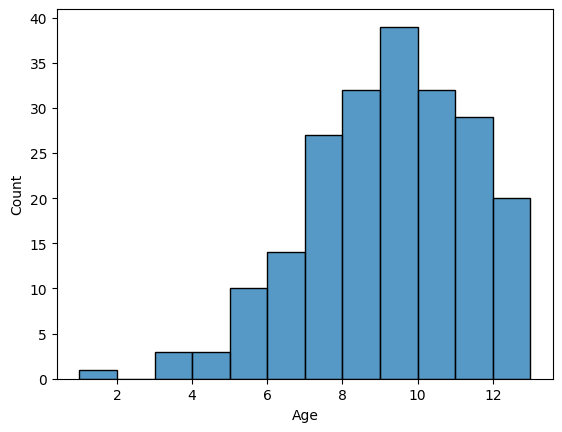

In [ ]:
# Convert 'Age' into ordered-categorical data (categorize in  5 years)  (ex. 15~19 -> "0"/ 20~24 -> "1")
# same cut-off value with PRO-ACT Preprocessing
age_min = 15

def cat_age(age, age_min):
  return (age - age_min) // 5

demographics['Age'] = demographics.apply(lambda x: cat_age(x['Age'], age_min), axis = 1)
sns.histplot(demographics['Age'])

In [ ]:
# Female = 0, Male = 1
demographics = demographics.replace({'Gender':{"F":0, "M":1}})
demographics

,SubjectID,Gender,Age
0,11872.0,1,10.0
1,11871.0,1,9.0
177,1654.0,1,7.0
181,1650.0,0,9.0
188,1642.0,1,11.0
...,...,...,...
792,1031.0,1,11.0
793,1030.0,1,7.0
802,1021.0,0,5.0
804,1019.0,0,9.0


## (2) ALS history

In [ ]:
ALS_hx_v2 = ALS_hx.query("Study_ID == {0}".format(patient_list))
ALS_hx_v2

,Study_ID,onset_site,onset_delta,diag_delta,diag_minus_onset
0,11872.0,0,13.0,0.0,-13.0
1,11871.0,1,12.0,2.0,-10.0
176,1654.0,0,9.0,4.0,-5.0
180,1650.0,1,16.0,3.0,-13.0
187,1642.0,0,43.0,1.0,-42.0
...,...,...,...,...,...
793,1031.0,0,4.0,0.0,-4.0
794,1030.0,0,13.0,0.0,-13.0
803,1021.0,0,26.0,1.0,-25.0
805,1019.0,0,17.0,5.0,-12.0


In [ ]:
ALS_hx_v2 = ALS_hx_v2.rename(columns={'Study_ID':'SubjectID'})

## (3) ALSFRS mean & slope for the first 3 months

In [ ]:
# Define function calculating mean
def cal_mean(df):
  df_mean = df.groupby('SubjectID').agg('mean')
  df_mean.reset_index(inplace=True) # reset 'SubjectiD' as column

  mean_df = pd.DataFrame(df_mean['SubjectID'])
  feature_list = list(df.drop(columns = ['SubjectID', 'feature_delta']).columns)

  for feature in feature_list:
    mean_df['mean_'+feature] = df_mean[feature]

  return mean_df

In [ ]:
# Define function calculating slope (Linear regression)
from sklearn.linear_model import LinearRegression
def cal_slope_LR(df):
    df_first_last = df.groupby('SubjectID').agg(['first', 'last'])
    df_first_last.reset_index(inplace=True) # reset 'SubjectiD' as column
    df_first_last['interval'] = df_first_last[('feature_delta','last')] - df_first_last[('feature_delta','first')]
    df_first_last = df_first_last[df_first_last['interval']>=1.5] # exclude data that is observed in little interval
    df =  df.query("SubjectID == {0}".format(df_first_last['SubjectID'].unique().tolist()))

    features = list(df.drop(columns = ['SubjectID', 'feature_delta']).columns)
    result = pd.DataFrame(columns=["SubjectID"] + [f"slope_{feature}" for feature in features])
    for subject_id, subject_data in df.groupby("SubjectID"):
        slopes = []
        for feature in features:
            X = subject_data[["feature_delta"]].values
            y = subject_data[feature].values
            model = LinearRegression()
            model.fit(X, y)
            slope = model.coef_[0]
            slopes.append(slope)
        result = result.append(pd.DataFrame([[subject_id] + slopes], columns=result.columns))

    return result

In [ ]:
# Define function calculating for time-resolved features
def cal_time_resolved(df):
  # Filter first 3 month data
  df_3mo = df.query('(feature_delta <= 3.0) and (feature_delta >= 0)')

  # Calculate mean
  mean_df = cal_mean(df_3mo)

  # Calculate slope
  slope_df = cal_slope_LR(df_3mo)

  # Merge mean & slope data (outer join)
  df_summary =  mean_df.merge(slope_df, on = 'SubjectID', how='outer')

  return df_summary

In [ ]:
alsfrs_R_cleaned = sixth_filtered_frs.copy()
alsfrs_R_cleaned

,SubjectID,feature_delta,Q1_Speech,Q2_Salivation,Q3_Swallowing,Q4_Handwriting,Q6_Dressing_and_Hygiene,Q7_Turning_in_Bed,Q8_Walking,Q9_Climbing_Stairs,R1_Dyspnea,R2_Orthopnea,R3_Respiratory_Insufficiency,ALSFRS_R_Total,Q5_Cutting
17,1005.0,0.920548,4.0,4.0,4.0,1.0,1.0,1.0,3.0,1.0,4.0,4.0,4.0,33.0,4.0
18,1005.0,7.134247,3.0,4.0,4.0,1.0,0.0,2.0,1.0,0.0,4.0,4.0,4.0,28.0,0.0
19,1005.0,11.046575,3.0,4.0,3.0,0.0,1.0,1.0,2.0,1.0,4.0,4.0,4.0,28.0,0.0
20,1005.0,13.808219,4.0,4.0,4.0,0.0,0.0,1.0,1.0,0.0,4.0,4.0,4.0,27.0,0.0
21,1005.0,16.339726,4.0,4.0,4.0,0.0,0.0,1.0,2.0,1.0,4.0,4.0,4.0,29.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1477,11872.0,0.000000,4.0,4.0,4.0,4.0,4.0,4.0,2.0,2.0,4.0,4.0,4.0,44.0,4.0
1478,11872.0,4.109589,4.0,4.0,4.0,4.0,3.0,3.0,2.0,1.0,4.0,4.0,4.0,40.0,3.0
1479,11872.0,5.950685,4.0,4.0,4.0,4.0,3.0,3.0,1.0,0.0,4.0,4.0,4.0,38.0,3.0
1480,11872.0,10.323288,4.0,4.0,4.0,3.0,3.0,2.0,1.0,0.0,4.0,4.0,4.0,35.0,2.0


In [ ]:
# Add alsfrs-3dimension scores
alsfrs_R_cleaned['bulbar'] = alsfrs_R_cleaned['Q1_Speech']+alsfrs_R_cleaned['Q3_Swallowing']
alsfrs_R_cleaned['motor'] = alsfrs_R_cleaned['Q4_Handwriting']+alsfrs_R_cleaned['Q5_Cutting']+alsfrs_R_cleaned['Q6_Dressing_and_Hygiene']+alsfrs_R_cleaned['Q7_Turning_in_Bed']+alsfrs_R_cleaned['Q8_Walking']+alsfrs_R_cleaned['Q9_Climbing_Stairs']
alsfrs_R_cleaned['respiratory_R'] = alsfrs_R_cleaned['R1_Dyspnea']+alsfrs_R_cleaned['R2_Orthopnea']+alsfrs_R_cleaned['R3_Respiratory_Insufficiency']

In [ ]:
# Calculate
alsfrs_R_cleaned_3mo = alsfrs_R_cleaned.query('feature_delta <= 3.0')
alsfrs_R_cleaned_3mo = alsfrs_R_cleaned_3mo.astype('float')
alsfrs_R_summary = cal_time_resolved(alsfrs_R_cleaned_3mo)

In [ ]:
alsfrs_R_summary

,SubjectID,mean_Q1_Speech,mean_Q2_Salivation,mean_Q3_Swallowing,mean_Q4_Handwriting,mean_Q6_Dressing_and_Hygiene,mean_Q7_Turning_in_Bed,mean_Q8_Walking,mean_Q9_Climbing_Stairs,mean_R1_Dyspnea,...,slope_Q8_Walking,slope_Q9_Climbing_Stairs,slope_R1_Dyspnea,slope_R2_Orthopnea,slope_R3_Respiratory_Insufficiency,slope_ALSFRS_R_Total,slope_Q5_Cutting,slope_bulbar,slope_motor,slope_respiratory_R
0,1005.0,4.0,4.000000,4.0,1.000000,1.000000,1.000000,3.000000,1.000000,4.000000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1019.0,4.0,4.000000,3.5,3.000000,2.500000,3.000000,3.000000,1.500000,4.000000,...,0.000000,-0.334249,0.000000,0.0,0.0,-1.002747,0.334249,-0.334249,-0.334249,0.000000
2,1021.0,4.0,4.000000,4.0,4.000000,4.000000,4.000000,3.000000,2.000000,4.000000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1030.0,4.0,4.000000,4.0,3.000000,4.000000,4.000000,4.000000,4.000000,3.000000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1031.0,4.0,4.000000,3.5,2.500000,2.500000,2.000000,3.000000,1.000000,4.000000,...,0.000000,0.000000,0.000000,0.0,0.0,0.790043,0.000000,0.395022,0.790043,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
205,1642.0,4.0,4.000000,3.5,3.000000,3.000000,3.000000,3.000000,2.500000,4.000000,...,0.000000,-0.475260,0.000000,0.0,0.0,0.000000,0.000000,0.475260,-0.475260,0.000000
206,1650.0,2.0,2.666667,3.0,3.666667,3.333333,3.333333,3.333333,2.666667,3.666667,...,-0.415599,-0.344168,-0.344168,0.0,0.0,-3.039069,0.000000,0.487030,-1.935134,-0.344168
207,1654.0,4.0,4.000000,4.0,4.000000,4.000000,4.000000,3.000000,3.000000,4.000000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
208,11871.0,3.0,3.000000,3.0,2.000000,3.000000,3.000000,3.000000,3.000000,4.000000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## (4) FVC

In [ ]:
fvc = pd.read_csv('/content/drive/MyDrive/Predicting Loss of Autonomy/Raw data/SNUH/snuh_fvc_20211025.csv')

In [ ]:
fu = pyreadr.read_r('/content/drive/MyDrive/Predicting Loss of Autonomy/Raw data/SNUH/fu.rds')[None]

In [ ]:
wt = pyreadr.read_r('/content/drive/MyDrive/Predicting Loss of Autonomy/Raw data/SNUH/fu_wt.rds')[None]

In [ ]:
cr = pd.read_csv('/content/drive/MyDrive/Predicting Loss of Autonomy/Raw data/SNUH/snuh_cr.csv')

In [ ]:
fvc = fvc[['Study_ID','Date_visit', 'FVC_percent']].query("Study_ID == {0}".format(patient_list))
fvc

,Study_ID,Date_visit,FVC_percent
4,1005,2018.3.12,71
5,1005,2017.9.11,77
6,1005,2017.5.15,77
7,1005,2018.8.27,58
8,1005,2019.5.13,31
...,...,...,...
250,11871,2017.12.27,96
251,11871,2018.10.1,115
252,11872,2019.4.15,94
253,11872,2018.6.11,106


In [ ]:
# additional FVC record might exist from 'fu' data
fu.columns = ['Study_ID', 'Date_visit', 'Wt', 'ALSFRS', 'FVC_percent']
fu['Hosp_ID'] = np.nan
fu_fvc = fu[~fu['FVC_percent'].isnull()][['Study_ID', 'Date_visit', 'FVC_percent']]
fu_fvc

,Study_ID,Date_visit,FVC_percent
1449,1353.0,2022-03-07,51.0
2288,1564.0,2021-12-20,13.0
2349,1577.0,2021-06-28,82.0
2564,1650.0,2021-05-18,79.0
2608,1703.0,2021-10-27,44.0
2628,1708.0,2021-10-22,84.0
2643,1714.0,2021-10-19,75.0
2661,1727.0,2021-08-23,12.0
2668,1735.0,2021-10-12,71.0
2690,1742.0,2021-09-14,72.0


In [ ]:
FVC = pd.concat([fvc, fu_fvc]).sort_values('Study_ID')
FVC.drop_duplicates(subset=None, keep='first', inplace=True)
FVC.drop_duplicates(subset=['Study_ID', 'Date_visit'], keep=False, inplace=True)
FVC

,Study_ID,Date_visit,FVC_percent
4,1005.0,2018.3.12,71.0
5,1005.0,2017.9.11,77.0
6,1005.0,2017.5.15,77.0
7,1005.0,2018.8.27,58.0
8,1005.0,2019.5.13,31.0
...,...,...,...
250,11871.0,2017.12.27,96.0
251,11871.0,2018.10.1,115.0
254,11872.0,2017.12.19,98.0
252,11872.0,2019.4.15,94.0


In [ ]:
FVC[FVC.duplicated(subset=['Study_ID', 'Date_visit'], keep=False)== True] # No duplicates

,Study_ID,Date_visit,FVC_percent


In [ ]:
FVC.rename(columns = {'Study_ID':'SubjectID', 'FVC_percent':'fvc'},inplace=True)
FVC = cal_feature_delta(FVC, date_enroll)

In [ ]:
fvc_summary = cal_time_resolved(FVC)
fvc_summary

,SubjectID,mean_fvc,slope_fvc
0,1005.0,77.0,NaN
1,1030.0,76.0,NaN
2,1031.0,89.0,NaN
3,1035.0,78.0,NaN
4,1037.0,80.0,NaN
...,...,...,...
88,1758.0,59.0,NaN
89,1846.0,95.0,NaN
90,1897.0,33.0,NaN
91,11871.0,96.0,NaN


## (5) weight

In [ ]:
wt = wt[['Study_ID', 'Date', 'Wt']].query("Study_ID == {0}".format(patient_list))
wt

,Study_ID,Date,Wt
81,1005.0,2019-05-13,65.0
82,1005.0,2019-02-11,67.0
83,1005.0,2018-11-19,67.0
84,1005.0,2018-08-27,67.0
85,1005.0,2018-06-11,67.0
...,...,...,...
2613,11872.0,2019-04-15,85.0
2614,11872.0,2018-10-22,88.0
2615,11872.0,2018-06-11,86.0
2616,11872.0,2018-04-16,87.0


In [ ]:
# additional weight record might exist from 'fu' data
fu_wt = fu[~fu['Wt'].isnull()][['Study_ID', 'Date_visit', 'Wt']]
fu_wt.columns = ['Study_ID','Date', 'Wt']
fu_wt

,Study_ID,Date,Wt
0,1.0,2012-02-01,65.0
1,3.0,2012-02-10,46.0
2,4.0,2012-02-09,57.0
6,5.0,2012-02-22,78.0
7,7.0,2012-03-19,74.0
...,...,...,...
2935,11872.0,2019-04-15,85.0
2936,11872.0,2018-10-22,88.0
2937,11872.0,2018-06-11,86.0
2938,11872.0,2018-04-16,87.0


In [ ]:
WT = pd.concat([wt, fu_wt]).sort_values('Study_ID')
WT

,Study_ID,Date,Wt
0,1.0,2012-02-01,65.0
1,3.0,2012-02-10,46.0
2,4.0,2012-02-09,57.0
6,5.0,2012-02-22,78.0
7,7.0,2012-03-19,74.0
...,...,...,...
2613,11872.0,2019-04-15,85.0
2614,11872.0,2018-10-22,88.0
2615,11872.0,2018-06-11,86.0
2617,11872.0,2017-12-12,85.0


In [ ]:
WT.drop_duplicates(subset=None, keep='first', inplace=True)
WT.drop_duplicates(subset=['Study_ID', 'Date'], keep=False, inplace=True)
WT

,Study_ID,Date,Wt
0,1.0,2012-02-01,65.0
1,3.0,2012-02-10,46.0
2,4.0,2012-02-09,57.0
6,5.0,2012-02-22,78.0
7,7.0,2012-03-19,74.0
...,...,...,...
2935,11872.0,2019-04-15,85.0
2936,11872.0,2018-10-22,88.0
2937,11872.0,2018-06-11,86.0
2616,11872.0,2018-04-16,87.0


In [ ]:
WT.sort_values(by='Date', ascending=True) # errorneous Date was checked '0202-07-18'. this observation will be treated as missing data

,Study_ID,Date,Wt
1806,1514.0,0202-07-18,57.0
0,1.0,2012-02-01,65.0
2,4.0,2012-02-09,57.0
1,3.0,2012-02-10,46.0
6,5.0,2012-02-22,78.0
...,...,...,...
2465,1619.0,2022-08-02,66.0
2902,1903.0,2022-08-03,48.0
1740,1429.0,2022-08-03,47.0
2165,1539.0,2022-08-03,92.3


In [ ]:
WT = WT.query("(Study_ID != 1514) or (Wt!=57)") #because his Date_visit was errorneous

In [ ]:
WT.rename(columns = {'Study_ID':'SubjectID', 'Date':'Date_visit', 'Wt':'weight'},inplace=True)

In [ ]:
weight = cal_feature_delta(WT, date_enroll)
weight_summary = cal_time_resolved(weight)

In [ ]:
weight_summary

,SubjectID,mean_weight,slope_weight
0,1000.0,69.0,NaN
1,1001.0,77.5,-0.366466
2,1002.0,55.0,0.000000
3,1003.0,62.0,0.000000
4,1004.0,59.0,NaN
...,...,...,...
776,11851.0,66.0,NaN
777,11852.0,50.0,NaN
778,11861.0,64.0,NaN
779,11862.0,39.0,NaN


## (6) creatinine

In [ ]:
cr = cr.query("Study_ID == {0}".format(patient_list)) #include only ALS patients
cr.rename(columns = {'Study_ID':'SubjectID', 'Date':'Date_visit', 'Cr':'creatinine'},inplace=True)
cr

<ipython-input-199-b1f9f550abde>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cr.rename(columns = {'Study_ID':'SubjectID', 'Date':'Date_visit', 'Cr':'creatinine'},inplace=True)


,SubjectID,Date_visit,creatinine
0,11872,2017-12-17,0.69
1,11871,2017-12-26,0.88
2,11871,2018-01-08,0.94
3,11871,2018-01-02,0.85
6,1650,2021-07-07,0.68
...,...,...,...
1038,1005,2020-01-23,0.31
1039,1005,2020-01-19,0.17
1040,1005,2020-01-27,0.50
1041,1005,2020-01-22,0.43


In [ ]:
cr[cr['creatinine']=='#VALUE!'] # these patients will be treated as missing data

,SubjectID,Date_visit,creatinine


In [ ]:
#adjust the measure unit (from mg/dL to micromol/L)
cr[['creatinine']] = cr[['creatinine']].apply(pd.to_numeric)
cr['creatinine_mmol_per_liter'] = cr['creatinine']*88.4
cr = cr[['SubjectID', 'Date_visit', 'creatinine_mmol_per_liter']]
cr.columns = ['SubjectID', 'Date_visit', 'creatinine']
cr.sort_values('Date_visit')

,SubjectID,Date_visit,creatinine
960,1046,2017-02-16,53.040
925,1111,2017-02-23,70.720
995,1021,2017-03-13,53.040
948,1062,2017-04-03,65.416
997,1021,2017-04-24,51.272
...,...,...,...
161,1514,2021-07-20,60.112
50,1587,2021-07-26,58.344
86,1562,2021-07-26,101.660
529,1401,2021-07-29,38.896


In [ ]:
creatinine = cal_feature_delta(cr, date_enroll)
creatinine = creatinine.astype('float')
creatinine_summary = cal_time_resolved(creatinine)
creatinine_summary.columns=['SubjectID', 'mean_Creatinine', 'slope_Creatinine']

In [ ]:
creatinine_summary

,SubjectID,mean_Creatinine,slope_Creatinine
0,1005.0,71.309333,NaN
1,1021.0,45.968000,-1.321649
2,1030.0,67.184000,NaN
3,1031.0,67.714400,4.638532
4,1035.0,70.720000,NaN
...,...,...,...
101,1620.0,59.228000,NaN
102,1629.0,56.576000,NaN
103,1642.0,72.488000,NaN
104,11871.0,79.118000,NaN


## (7) Merge all features and target variable

In [ ]:
demographics

,Study_ID,Gender,Age
0,11872.0,1,10.0
1,11871.0,1,9.0
177,1654.0,1,7.0
181,1650.0,0,9.0
188,1642.0,1,11.0
...,...,...,...
792,1031.0,1,11.0
793,1030.0,1,7.0
802,1021.0,0,5.0
804,1019.0,0,9.0


In [ ]:
# Outer join all features to allow missing data
features_df = pd.DataFrame(columns=['SubjectID'])
feature_list = [demographics, ALS_hx_v2, alsfrs_R_summary, fvc_summary, creatinine_summary, weight_summary]
for i in feature_list :
    df = i
    features_df = features_df.merge(df, on='SubjectID', how='outer')
features_snuh = features_df.query("SubjectID == {0}".format(patient_list))
features_snuh

,SubjectID,Gender,Age,onset_site,onset_delta,diag_delta,diag_minus_onset,mean_Q1_Speech,mean_Q2_Salivation,mean_Q3_Swallowing,...,slope_Q5_Cutting,slope_bulbar,slope_motor,slope_respiratory_R,mean_fvc,slope_fvc,mean_Creatinine,slope_Creatinine,mean_weight,slope_weight
0,11872.0,1.0,10.0,0,13.0,0.0,-13.0,4.0,4.000000,4.0,...,NaN,NaN,NaN,NaN,98.0,NaN,60.996000,NaN,85.0,NaN
1,11871.0,1.0,9.0,1,12.0,2.0,-10.0,3.0,3.000000,3.0,...,NaN,NaN,NaN,NaN,96.0,NaN,79.118000,NaN,NaN,NaN
2,1654.0,1.0,7.0,0,9.0,4.0,-5.0,4.0,4.000000,4.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,62.0,NaN
3,1650.0,0.0,9.0,1,16.0,3.0,-13.0,2.0,2.666667,3.0,...,0.000000,0.487030,-1.935134,-0.344168,79.0,NaN,NaN,NaN,48.0,0.00000
4,1642.0,1.0,11.0,0,43.0,1.0,-42.0,4.0,4.000000,3.5,...,0.000000,0.475260,-0.475260,0.000000,NaN,NaN,72.488000,NaN,63.5,-0.47526
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
205,1031.0,1.0,11.0,0,4.0,0.0,-4.0,4.0,4.000000,3.5,...,0.000000,0.395022,0.790043,0.000000,89.0,NaN,67.714400,4.638532,67.0,0.00000
206,1030.0,1.0,7.0,0,13.0,0.0,-13.0,4.0,4.000000,4.0,...,NaN,NaN,NaN,NaN,76.0,NaN,67.184000,NaN,64.0,NaN
207,1021.0,0.0,5.0,0,26.0,1.0,-25.0,4.0,4.000000,4.0,...,NaN,NaN,NaN,NaN,NaN,NaN,45.968000,-1.321649,75.0,NaN
208,1019.0,0.0,9.0,0,17.0,5.0,-12.0,4.0,4.000000,3.5,...,0.334249,-0.334249,-0.334249,0.000000,NaN,NaN,NaN,NaN,56.0,0.00000


In [ ]:
Features_and_Target_final_snuh = features_snuh.merge(Target_Data_snuh, on='SubjectID', how='outer')
Features_and_Target_final_snuh.sort_values(by='SubjectID', ascending=True, inplace=True)
Features_and_Target_final_snuh = Features_and_Target_final_snuh.query("SubjectID == {0}".format(patient_list))
Features_and_Target_final_snuh

,SubjectID,Gender,Age,onset_site,onset_delta,diag_delta,diag_minus_onset,mean_Q1_Speech,mean_Q2_Salivation,mean_Q3_Swallowing,...,slope_motor,slope_respiratory_R,mean_fvc,slope_fvc,mean_Creatinine,slope_Creatinine,mean_weight,slope_weight,time_LOA,status_LOA
209,1005.0,1.0,3.0,0,5.0,2.0,-3.0,4.0,4.000000,4.0,...,NaN,NaN,77.0,NaN,71.309333,NaN,69.0,0.00000,27.378082,1
208,1019.0,0.0,9.0,0,17.0,5.0,-12.0,4.0,4.000000,3.5,...,-0.334249,0.000000,NaN,NaN,NaN,NaN,56.0,0.00000,17.515068,0
207,1021.0,0.0,5.0,0,26.0,1.0,-25.0,4.0,4.000000,4.0,...,NaN,NaN,NaN,NaN,45.968000,-1.321649,75.0,NaN,44.769863,0
206,1030.0,1.0,7.0,0,13.0,0.0,-13.0,4.0,4.000000,4.0,...,NaN,NaN,76.0,NaN,67.184000,NaN,64.0,NaN,21.394521,1
205,1031.0,1.0,11.0,0,4.0,0.0,-4.0,4.0,4.000000,3.5,...,0.790043,0.000000,89.0,NaN,67.714400,4.638532,67.0,0.00000,20.013699,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4,1642.0,1.0,11.0,0,43.0,1.0,-42.0,4.0,4.000000,3.5,...,-0.475260,0.000000,NaN,NaN,72.488000,NaN,63.5,-0.47526,1.832877,0
3,1650.0,0.0,9.0,1,16.0,3.0,-13.0,2.0,2.666667,3.0,...,-1.935134,-0.344168,79.0,NaN,NaN,NaN,48.0,0.00000,0.484932,0
2,1654.0,1.0,7.0,0,9.0,4.0,-5.0,4.0,4.000000,4.0,...,NaN,NaN,NaN,NaN,NaN,NaN,62.0,NaN,0.221918,0
1,11871.0,1.0,9.0,1,12.0,2.0,-10.0,3.0,3.000000,3.0,...,NaN,NaN,96.0,NaN,79.118000,NaN,NaN,NaN,9.361644,0


### Check missing data proportion

The column slope_Q1_Speech has 124 null values. It is 59.05% of total rows.
The column slope_Q1_Speech is of type float64.

The column slope_Q2_Salivation has 124 null values. It is 59.05% of total rows.
The column slope_Q2_Salivation is of type float64.

The column slope_Q3_Swallowing has 124 null values. It is 59.05% of total rows.
The column slope_Q3_Swallowing is of type float64.

The column slope_Q4_Handwriting has 124 null values. It is 59.05% of total rows.
The column slope_Q4_Handwriting is of type float64.

The column slope_Q6_Dressing_and_Hygiene has 124 null values. It is 59.05% of total rows.
The column slope_Q6_Dressing_and_Hygiene is of type float64.

The column slope_Q7_Turning_in_Bed has 124 null values. It is 59.05% of total rows.
The column slope_Q7_Turning_in_Bed is of type float64.

The column slope_Q8_Walking has 124 null values. It is 59.05% of total rows.
The column slope_Q8_Walking is of type float64.

The column slope_Q9_Climbing_Stairs has 124 null values. It 

['slope_Q1_Speech',
 'slope_Q2_Salivation',
 'slope_Q3_Swallowing',
 'slope_Q4_Handwriting',
 'slope_Q6_Dressing_and_Hygiene',
 'slope_Q7_Turning_in_Bed',
 'slope_Q8_Walking',
 'slope_Q9_Climbing_Stairs',
 'slope_R1_Dyspnea',
 'slope_R2_Orthopnea',
 'slope_R3_Respiratory_Insufficiency',
 'slope_ALSFRS_R_Total',
 'slope_Q5_Cutting',
 'slope_bulbar',
 'slope_motor',
 'slope_respiratory_R',
 'mean_fvc',
 'slope_fvc',
 'mean_Creatinine',
 'slope_Creatinine',
 'slope_weight']

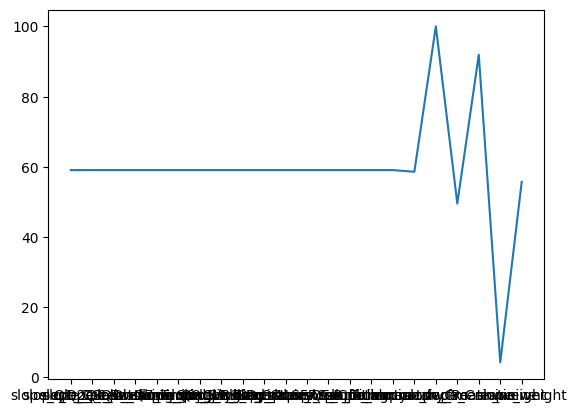

In [ ]:
def report_nulls(df):
    '''
    Show a fast report of the DF.
    '''
    rows = df.shape[0]
    columns = df.shape[1]
    null_cols = 0
    list_of_nulls_cols = []
    list_of_nulls_cols_pcn = []
    list_of_nulls_cols_over40 = []
    for col in list(df.columns):
        null_values_rows = df[col].isnull().sum()
        null_rows_pcn = round(((null_values_rows)/rows)*100, 2)
        col_type = df[col].dtype
        if null_values_rows > 0:
            print("The column {} has {} null values. It is {}% of total rows.".format(col, null_values_rows, null_rows_pcn))
            print("The column {} is of type {}.\n".format(col, col_type))
            null_cols += 1
            list_of_nulls_cols.append(col)
            list_of_nulls_cols_pcn.append(null_rows_pcn)
            if null_rows_pcn > 40:
                list_of_nulls_cols_over40.append(col)
    null_cols_pcn = round((null_cols/columns)*100, 2)
    print("The DataFrame has {} columns with null values. It is {}% of total columns.".format(null_cols, null_cols_pcn))
    plt.plot(list_of_nulls_cols, list_of_nulls_cols_pcn)
    return list_of_nulls_cols_over40

report_nulls(Features_and_Target_final_snuh)

## Save to preprocessed_csv files

In [ ]:
Features_and_Target_final_snuh.to_csv('/content/drive/MyDrive/Predicting Loss of Autonomy/1. Swallowing/Files/X_and_Y_SNUH_with_NaNs.csv')